<p style="text-align: center;font-size: 40pt">Localization and mapping</p>

In [2]:
%matplotlib inline

from IPython.display import HTML, YouTubeVideo


%run ./scripts/helper_func.py
path = "{0}/common/scripts/style.py".format(get_root_path())
%run $path

# The problem of SLAM

This acronym is very important for autonomous vehicles and it stands for Simultaneous Localization and Mapping.
As a short explanation, the main problem that SLAM tried to solve is twofold.
On one side, if you have a perfect 3D map of the environment, it is easy to localize in that environment using you sensors.
On the other side, if you know perfectly where is your vehicle is at all times, you just need to stitch you sensor information to construct a map of the environment.
Now, if you don't have either, which is most of the case when you're exploring a new environment, you need to localize and map your environment at the same time.
These actions are achieved using three steps:
1. **prediction**: given your physical model of the vehicle and your current state (i.e., position, velocity, and acceleration), you try to predict where the vehicle will be at the time interval.
1. **measurement**: after the time interval as passed, you estimate where the vehicle is.
1. **update**: you minimize the error from your prediction and your measurement.

Key challenges related to SLAM are:
- State estimation / state fusion
- Map representations;
- Loop detection / alignment error recovery; and
- Data management;

with the two first points being related to 3D registration algorithms.
We will see in detail what are those registration algorithms during this lecture, but at this stage, you only need to know that it is an algorithm that allows you to minimize the alignment error between two representation of the environment.
For example, in the following video, a registration algorithm was used to align the cube in red with the cube in gray through an iterative process:

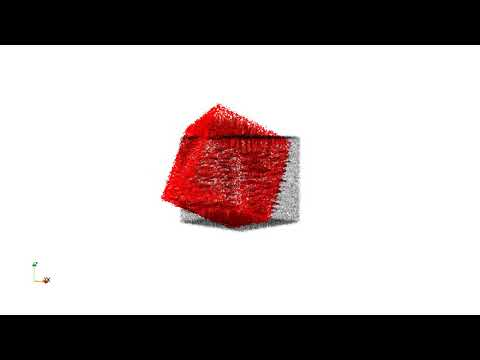

In [3]:
YouTubeVideo('_e1s0QaYBkw', width=720, height=480)


With that in mind, there are two main types of registration used in robotics:

- **photometric**: this is typically measured by cameras which record the energy from an other source reflected on surfaces (i.e., what you know as a regular images), or the energy emitted by a surface (i.e., thermal images).
- **geometric**: this is typically measured by lidars or can be generated by triangulation from 2D sensors leading to the estimation of position, surface, and volume.

# Camera versus lidars

At this time, you might know that Elon Musk said:
> _"Lidar is a fool's errand... Anyone relying on lidar is doomed."_ &mdash;  Elon Musk, 2019

This is mainly related to cost from the automotive industry point of view so, although that comment is related to this lesson, it is not relevant.
The goal here is not to start a fight, but simply to make a difference between registration algorithms relying on those two sensors.
The following table summarize these differences:

<p style="text-align: center;">
    <img src="images/slam/cam_vs_lidar.jpg" width="70%" alt="">
    <br>
    Table comparing information from cameras (photometric) to lidars (geometric) with the specific use case of registration algorithms.
</p>

The concept of texture for an image is rather easy to grasp.
When there are a lot of changes in color and intensity, it is easy to detect a lot of features (e.g., edges) and track them to resolve an alignment error.
If these features are on a wall or on a table, there will be nothing to track when looking only at geometric information.
The following figure highlight that difference:


<p style="text-align: center;">
    <img src="images/slam/texture_cam.jpg" width="70%" alt="">
    <br>
    Left: low resolution image of posters laying down on a table.
    Right: depth image of the exact same scene, where there would not be enough information to resolve alignment errors.
</p>

Textures, in the geometric sense, mean that the environment has surfaces with enough different orientation to constrain the sensor pose.
When there are changes in 3D structure, this typically also cast shadows generating plenty of features in an image.
The following images shows this situation:

<p style="text-align: center;">
    <img src="images/slam/texture_lidar_light.jpg" width="70%" alt="">
    <br>
    Left: low resolution image of a table with a lot of objects on it.
    Right: depth image of the exact same scene, where it would be easy to resolve alignment error.
</p>

Finally, there is the passive versus active sensor.
A passive sensor, such as a camera, use the energy produces by the scene and reflected to the sensor.
This energy source is typically the sun or some lamps.
Problems starts when there is not enough surrendering lights or the light shine directly in the sensor instead of being reflected, which will saturate the measurement.
The following figure compare active versus passive in low light condition:

<p style="text-align: center;">
    <img src="images/slam/texture_lidar_no_light.jpg" width="70%" alt="">
    <br>
    Left: low resolution image of a table with a lot of objects on it in a dark room.
    A flashlight was added to not show a simply black image.
    Right: depth image of the exact same scene, where there is no difference with the ambient light conditions.
</p>

# General state estimation solutions

It is rather important to be able to estimate the state of an autonomous vehicle related to its location (pose, velocity, and acceleration).
After all, most of the tasks expected from a vehicle are to move from a point A to a point B.
It would take a full lecture to cover all the aspects of 3D state estimation properly, but it's not the goal of this lesson to get close to that.
The good thing is that most of the 3D machinery explain in the theory part of this lecture are necessary to understand state estimation.
In this section, my goal is simply to quickly present the three types of solutions, which are
1. filter
1. window
1. global

We will explain those types of solution graphically instead of mathematically.
The trajectory of a vehicle is often depicted as the following figure.
Triangles is a conceptual representation of the state of the vehicle.
You can think as those triangles showing the position and orientation of the vehicle at that time, but you need to recall that states may include velocity and acceleration.
Then, there are links between those states, which put constraints on how one state transforms to another one.
For example, if you want to know the linear position of a car and you only have access to the acceleration of that car, the triangle (the state) would represent the distance from a starting position and the link between states would be acceleration and time.

<p style="text-align: center;">
    <img src="images/slam/trajectory.jpg" width="70%" alt="">
    <br>
    A general representation of state estimation depicted as a vehicle trajectory.
</p>

The first type of solutions, _filter_, will only use the last state to predict where the vehicle will be.
Then, sensors will produce a measurement and both the prediction and the measurement will be fused to produce the final estimate.
What is not depicted in the following figure showing this process is that both the prediction and the measurement have uncertainty and the resulting estimate is expected to have a lower uncertainty.
The key point to recall here is that, once the estimate is produced, it is fixed and will never change.

<p style="text-align: center;">
    <img src="images/slam/filter_pred.jpg" width="30%" alt="">
    <img src="images/slam/filter_mea.jpg" width="30%" alt="">
    <img src="images/slam/filter_est.jpg" width="30%" alt="">
    <br>
    Illustration of the filter solution for state estimation.
    Left: the prediction step.
    Middle: the measurement step.
    Right: the resulting estimate, which is a weighted average of the prediction and the measurement.
</p>

The second type of solution, _window_, does almost the same thing, but the optimization will adjust a group of states instead of only the current state.
The term window comes from the standard way to define the active state is by using a time window around the current time.
For example, you could parametrize your algorithm to optimize all states from the last 10 seconds.
The following figure illustrates that using an example with fours states being active.

<p style="text-align: center;">
    <img src="images/slam/window_pred.jpg" width="30%" alt="">
    <img src="images/slam/window_est.jpg" width="30%" alt="">
    <br>
    Illustration of the window solution for state estimation.
    Left: the prediction step and measurement steps.
    Right: the resulting estimate.
</p>

Finally, if you push the idea to its limit, we get the global solution where all the states are active.
This is typically useful when new information can modify all states.
This situation happen when a vehicle that was cumulating localization error and return to a known location.
We say that there is a loop closure at this moment, which is another constraint in the optimization process saying, for example, that there should not be more than two meter distance between the starting and ending pose.
When that detection happen, the error must be backpropagated through all the states to achieve a better estimate, as depicted in the next figure.
[This video](https://youtu.be/MNw-GeHHSuA?t=8) also illustrates well this concept.

<p style="text-align: center;">
    <img src="images/slam/global.jpg" width="30%" alt="">
    <img src="images/slam/global_loop.jpg" width="30%" alt="">
    <img src="images/slam/global_est.jpg" width="30%" alt="">
    <br>
    Illustration of the global solution for state estimation.
    Left: initial estimation of the states.
    Middle: detection of a loop closure with a large error.
    Right: backpropagation of the error through all the states.
</p>

Now, sensors such as wheel odometry, accelerometers, and gyroscopes give you directly a partial measurement of the state of a vehicle, but not a lidar or a camera.
This is where registration algorithms become handy as they measure the displacement between two states by minimizing the alignment error.
In other words, registration algorithms are one tool to add a line between triangles in our drawings of state estimation solutions.

# Extra

Not required for this lecture, but if you want to know more:
- H. Durrant-Whyte and T. Bailey, “Simultaneous localization and mapping: part I,” IEEE Robot. Automat. Mag., vol. 13, no. 2, pp. 99–110, 2006.
- T. Bailey and H. Durrant-Whyte, “Simultaneous localization and mapping (SLAM): part II,” IEEE Robot. Automat. Mag., vol. 13, no. 3, pp. 108–117, 2006.

Next lesson:
- [Overview of lidars](5-lesson_lidars.ipynb)

&#8635; [Go back to the list of lessons](0-overview.ipynb)